## Links
http://karpathy.github.io/2015/03/30/breaking-convnets/

https://ml.berkeley.edu/blog/2018/01/10/adversarial-examples/


### Time Spent on Reading on GAN paper/blogs and the Code

~4 hours 

### Instructions to run code

1) Have TF/Keras installed

2) Run the notebook

Disclaimer:
All code is my own and no code has been re-used from anywhere

In [68]:
import numpy as np
import random

import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras import backend as k

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (22,22)
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

In [69]:
# Load the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [70]:
# Pre-processing
RESHAPED = 784   # Make the image sequentioal
X_train = X_train.reshape(60000, RESHAPED)  # 60,000 train set
X_test = X_test.reshape(10000, RESHAPED)  # 10,000 test set
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize pixel values
X_train /= 255.0
X_test /= 255.0

In [71]:
# Convert class vectors to one-hot vectors for the DL models
NB_CLASSES = 10
Y_train = np_utils.to_categorical(y_train, NB_CLASSES)
Y_test = np_utils.to_categorical(y_test, NB_CLASSES)

In [72]:
# Close any previously open session
sess.close()

# Initialize session
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [73]:
############### MLP model ##############
model = Sequential()
model.add(Dense(512, input_shape=(RESHAPED,), activation='relu') )
model.add(Dropout(0.2))
# model.add(Dense(10, activation='softmax'))
model.add(Dense(10))
model.add(Activation("softmax"))
model.summary()

num_epochs = 3
#########################################

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                5130      
_________________________________________________________________
activation_7 (Activation)    (None, 10)                0         
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [74]:
# I tried the CNN model as well but the model doesn't really matter. All deep learning models are susceptible to the adverserial problem because their components are linear function.

############## CNN model ##############
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(2, 2), activation='relu',input_shape=(28, 28, 1), kernel_initializer='he_uniform', padding='same'))
# model.add(Conv2D(32, (2, 2), activation='relu',kernel_initializer='he_uniform', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
# model.add(Dense(10, activation='softmax'))
# model.summary()

# X_train = np.reshape(X_train, (-1, 28, 28, 1))
# X_test = np.reshape(X_test, (-1, 28, 28, 1))

# num_epochs = 3
########################################

In [75]:
# Compile & Train (Did not use any cross-validation set)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=num_epochs, batch_size = 128)

Epoch 1/3
60000/60000 [==============================] - 4s 62us/step - loss: 0.2840 - acc: 0.9193
Epoch 2/3
60000/60000 [==============================] - 3s 54us/step - loss: 0.1231 - acc: 0.9640
Epoch 3/3
60000/60000 [==============================] - 3s 55us/step - loss: 0.0840 - acc: 0.9751


In [76]:
# Predict the scores
predicted_digits_probs = model.predict(X_test)
predicted_digits_labels = np.argmax(predicted_digits_probs, axis=1)

In [77]:
# From the test set, pick ten instances of digit "2" which was predicted correctly by model
two_instances_index = []

while len(two_instances_index) < 10:
	rand_index = np.random.randint(0, 10000)
	if y_test[ rand_index ] == 2 and predicted_digits_labels[ rand_index ] == y_test[ rand_index ]:
		two_instances_index.append(rand_index)

### Create adversarial image of a 2 to be misclassified as a 6

In [78]:
y_true = np_utils.to_categorical(6, num_classes=10)
y_true = tf.convert_to_tensor(y_true, np.float32)

# Calculate the gradient of the loss function with respect to the image input
loss_tensor = keras.losses.categorical_crossentropy(y_true, model.output)    # model.layers[2].output
gradients = k.gradients(loss_tensor, model.input)[0]

# The ten instances of the digit "2"
New_Xs = X_test[ two_instances_index ]
partial_derivatives_mean = []


In [79]:
# Update the pixel values after each gradient calculation (gradients calculated via back-prop)
for _ in range(0,20):
	evaluated_gradients = sess.run(gradients,feed_dict={model.input: New_Xs, y_true: np_utils.to_categorical(6, num_classes=10) })
	partial_derivatives_mean.append( evaluated_gradients )
	New_Xs = New_Xs - (0.1* evaluated_gradients)

partial_derivatives_mean = np.array( partial_derivatives_mean )

# Take the mean
partial_derivatives_mean = np.mean( partial_derivatives_mean, axis = 0 )

In [80]:
# Predict the labels for the adverserial generated images
# The model weights are the same
predicted_digits_probs_ = model.predict(New_Xs)
predicted_digits_labels_ = np.argmax(predicted_digits_probs_, axis=1)
predicted_digits_probs_[0:10]
predicted_digits_labels_[0:10]

array([2, 6, 6, 6, 6, 6, 6, 6, 6, 6])

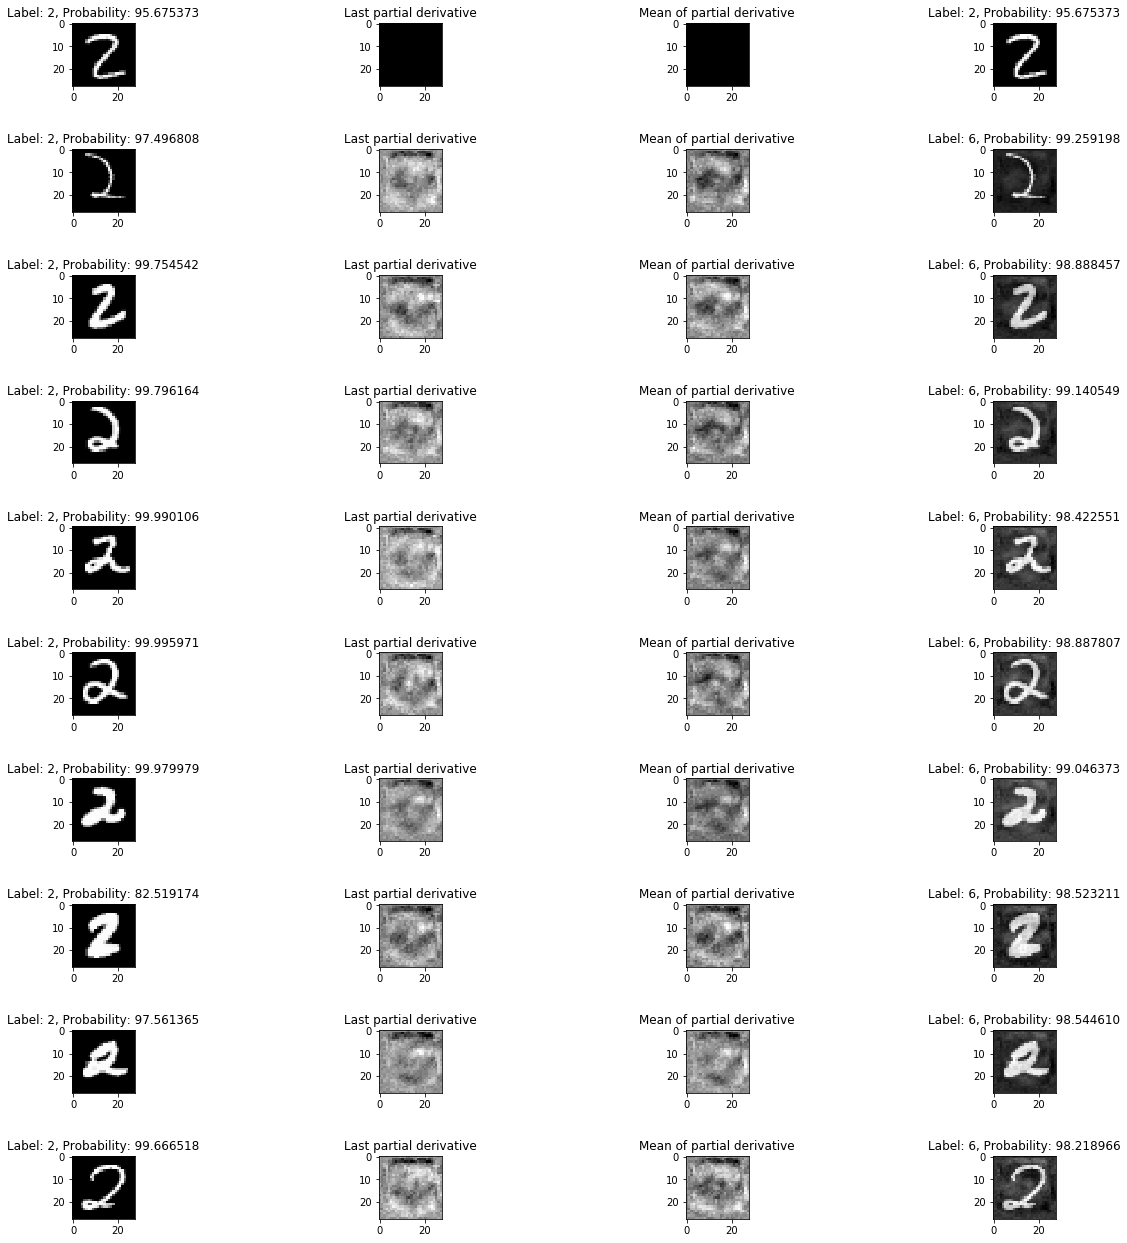

In [81]:
# Create 2x2 sub plots
gs = gridspec.GridSpec(10, 4, wspace=0, hspace=1)
pl.figure()

for i in range(0,10):
	ax = pl.subplot(gs[i, 0]) # row i, col 0
	plt.imshow(X_test[ two_instances_index[i] ].reshape(28,28), cmap='gray')
	plt.title('Label: 2, Probability: %f' % (predicted_digits_probs[two_instances_index][i][2] * 100) )
	
	ax = pl.subplot(gs[i, 1]) # row i, col 1
	plt.imshow(evaluated_gradients[i].reshape(28,28), cmap='gray')
	plt.title('Last partial derivative')
	
	ax = pl.subplot(gs[i, 2]) # row i, col 2
	plt.imshow(partial_derivatives_mean[i].reshape(28,28), cmap='gray')
	plt.title('Mean of partial derivative')
	
	ax = pl.subplot(gs[i, 3]) # row i, col 3
	plt.imshow(New_Xs[i].reshape(28,28), cmap='gray')
	plt.title('Label: %d, Probability: %f' % (predicted_digits_labels_[i], predicted_digits_probs_[i][predicted_digits_labels_[i]]*100  )  )

plt.show()

### Conclusion

The basic idea is to compute the gradients of the loss function with respect to the input image (ie. with respect to each of the 784 pixels) and to slightly change the pixel values using the computed gradients in order to fool the model to predict the digit "2" as being "6". We do this by keeping the model parameters constant and setting the y_goal as being the digit "6". We are optimizing our custom loss function by playing around with the image pixels instead of the model weights.

We can see that the calculated gradients for some of the 10 chosen images are all black (all zero). This may be due to the fact that the model predictions are confident (by looking at the original prediction probabilities) and thus the gradient of the softmax has saturated to be near zero.

I tried both a CNN and MLP model and it works with both. However, the model doesn't really matter. All deep learning models are susceptible to the adverserial problem because their components are linear function.

